# CNN pour la classification d'insectes
Ce notebook implémente un modèle simple de CNN pour classer les insectes à partir des images cropped.

In [155]:
# 📦 Imports
import os
import numpy as np
import pandas as pd
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
import seaborn as sns

In [156]:
# 📁 Filepaths and constants
IMAGE_DIR = "cropped/"  
MASK_DIR = "cropped/masks/"
IMAGE_SIZE = (64, 64)    
NUM_CHANNELS = 3  #RGB  

In [157]:
# 📥 Images and labels loading
def load_images_and_labels(df, image_column='ID', label_column='bug type', label_column2 = "reduced_bug_type"):
    X, y, y_red = [], [], []
    for _, row in df.iterrows():
        path = os.path.join(IMAGE_DIR, f"cropped_image_{row[image_column]}.png")
        if os.path.exists(path):
            img = imread(path)
            img_resized = resize(img, IMAGE_SIZE, preserve_range=True, anti_aliasing=True).astype(np.uint8)
            if img_resized.ndim == 2:
                img_resized = np.stack([img_resized]*3, axis=-1)
            X.append(img_resized)
            y.append(row[label_column])
            y_red.append(row[label_column2])
    return np.array(X), np.array(y), np.array(y_red)

In [158]:
# Loading dataframe from images and xlsx file
df_labels = pd.read_excel('classif.xlsx') 
df_labels["reduced_bug_type"] = df_labels["bug type"].apply(lambda x: x if x in ["Bee", "Bumblebee"] else "other")
X, y, y_red = load_images_and_labels(df_labels)

In [159]:
# Encoding labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_cat = to_categorical(y_encoded)

# Normalisation
X = X.astype("float32") / 255.0

# Split
X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Display train and val infos
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("Classes dans le train :", np.unique(np.argmax(y_train, axis=1), return_counts=True))
print("Classes dans le val   :", np.unique(np.argmax(y_val, axis=1), return_counts=True))

X_train: (199, 64, 64, 3)
y_train: (199, 6)
Classes dans le train : (array([0, 1, 2, 3, 4, 5]), array([85, 85, 13,  1,  7,  8]))
Classes dans le val   : (array([0, 1, 2, 4, 5]), array([30, 15,  2,  2,  1]))


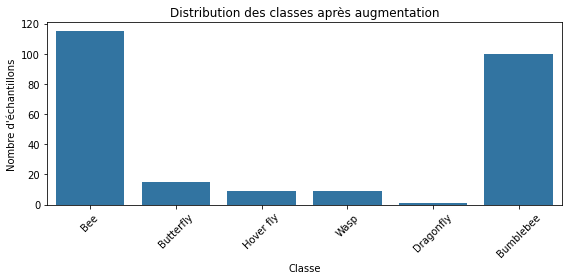

In [160]:
# Display distribution of classes
# Useful if pre data augmentation applied
labels_augmented = np.argmax(y_cat, axis=1)
label_names = le.inverse_transform(labels_augmented)

plt.figure(figsize=(8, 4))
sns.countplot(x=label_names)
plt.title("Distribution des classes après augmentation")
plt.xlabel("Classe")
plt.ylabel("Nombre d'échantillons")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [161]:
# 🧠 CNN model
model = Sequential([
    Input(shape=(64, 64, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_cat.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_38 (Conv2D)              │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_38 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_39 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_19 (Flatten)            │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,926 (6.20 MB)

 Trainable params: 1,625,926 (6.20 MB)

 Non-trainable params: 0 (0.00 B)

In [163]:
# Data augmentation
data_augmentation = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
)

Epoch 1/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.9700 - loss: 0.0602 - val_accuracy: 0.7200 - val_loss: 1.2540
Epoch 2/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.9694 - loss: 0.1267 - val_accuracy: 0.8000 - val_loss: 0.7207
Epoch 3/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - accuracy: 0.9909 - loss: 0.0413 - val_accuracy: 0.8400 - val_loss: 0.7539
Epoch 4/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9491 - loss: 0.1183 - val_accuracy: 0.7200 - val_loss: 0.9447
Epoch 5/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9388 - loss: 0.1226 - val_accuracy: 0.7800 - val_loss: 0.8071
Epoch 6/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9426 - loss: 0.1207 - val_accuracy: 0.8000 - val_loss: 0.7590
Epoch 7/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step - accuracy: 0.9775 - loss: 0.0967 - val_accuracy: 0.7600 - val_loss: 0.6060
Epoch 8/30
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.9864 - loss: 0.0478 - val_accuracy: 0.8200 - val_loss: 0.6692


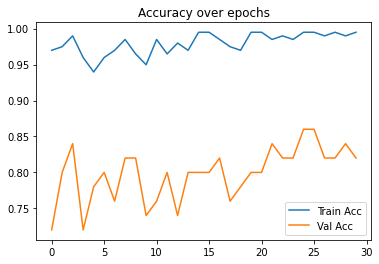

In [175]:
# 🚀 Training

early_stop = EarlyStopping(monitor='val_accuracy', patience=29, restore_best_weights=True, verbose=1)

# Callbacks
history = model.fit(data_augmentation.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val), 
                    epochs=30, 
                    batch_size=32,
                    callbacks=[early_stop])

# 📊 Accuracy evolution during training
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

In [176]:
# 📊 Evaluation
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_acc:.3f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8754 - loss: 0.6123
Validation Accuracy: 0.860


In [177]:
# Prediction on valitation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_val, axis=1)
print(np.bincount(y_true_classes))

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
[30 15  2  0  2  1]


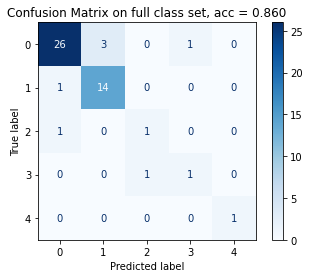

In [178]:
# 📈 Confusion matrice
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix on full class set, acc = {val_acc:.3f}")
plt.show()

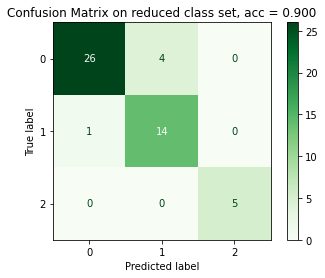

In [148]:
# 📈 Confusion matrice
cm = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Greens')
plt.title(f"Confusion Matrix on reduced class set, acc = {val_acc:.3f}")
plt.show()

In [179]:
# 💾 Save the trained model
model.save("full_classes_cnn.h5")